In [2]:
import pandas as pd

In [3]:
from pathlib import Path

# Specify the directory path
directory_path = Path('mappilary/train_val/')

# Get the list of directories in the specified directory
directories = [[entry.name] for entry in directory_path.iterdir() if entry.is_dir()]


In [4]:
directories = pd.DataFrame(directories, columns=['place'])
place = directories.sample(1).reset_index()['place'].loc[0]

In [5]:
df  = pd.read_csv(f"mappilary/train_val/{place}/database/postprocessed.csv")

In [6]:
df_raw = pd.read_csv(f"mappilary/train_val/{place}/database/raw.csv")


In [7]:
df = pd.merge(df, df_raw[['key', 'lat', 'lon']], on='key', how='left')


In [13]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx


In [14]:
geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]


In [15]:
# gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:32632")
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
# gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:32633")


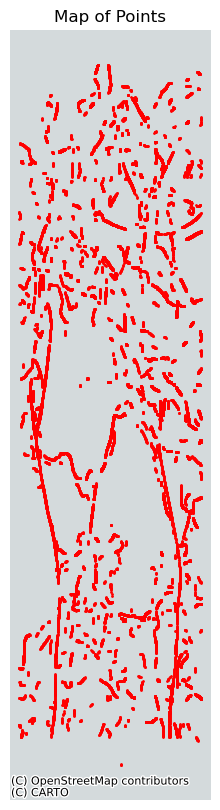

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=1)

# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()

plt.title('Map of Points')
plt.show()



In [17]:
# from pyproj import Transformer
# transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326")
# converted  = transformer.transform(df['northing'].values, df['easting'].values)
# df['latitude'] = converted[1]
# df['longitude'] = converted[0]


In [18]:
# print(f"{df['northing'][0]} {df['easting'][0]}")
# print(f"{df['latitude'][0]} {df['longitude'][0]}")
# df['latitude']

In [19]:
df['northing'][0]

6676107.23461674

In [20]:
import folium

import folium.plugins as plugins
from folium.plugins import HeatMap

map_center=[df['lat'].mean(), df['lon'].mean()]
# mymap = folium.Map(location=map_center, zoom_start=10)
mymap = folium.Map(location=map_center, tiles="Cartodb dark_matter", zoom_start=10)

# Add points to the map
# count = 10
# for index, row in df.sample(n=count).iterrows():
#     folium.Marker([row['lat'], row['lon']]).add_to(mymap)

HeatMap(data=df[['lat','lon']].groupby(['lat','lon']).sum().reset_index().values.tolist(), radius=7, max_zoom=10).add_to(mymap)


folium.TileLayer("CartoDB positron", show=False).add_to(
    mymap
)  # use folium to add alternative tiles
folium.LayerControl().add_to(mymap)  # use folium to add layer control
mymap

In [24]:
# from OSMPythonTools.overpass import Overpass
# overpass = Overpass()
sample  = 10
import overpy
api = overpy.Overpass()

lat , lon = [df['lat'][sample], df['lon'][sample]]
query = f"[out:json];nwr(around:100, {lat}, {lon});out;"
print(query)
result = api.query(query)
skip = set()
for way in result.ways:
    for node in way.get_nodes(resolve_missing=True):
        if len(node.tags) == 0:
            skip.add(node.id)
#     print(f" Name:{way.id} , tags: {way.tags} "  )

# for node in result.nodes:
#         if not node.id in skip:
#             print(f" Name:{node.id}   Lat: {node.lat}, Lon: {node.lon} way: {0}, tags: {node.tags} "  )

[out:json];nwr(around:100, 60.2056347, 24.8101164);out;


In [25]:
df.loc[sample]

Unnamed: 0                            10
key               QYieMit6TpLzoJAVIbrGKg
easting                    378627.146388
northing                  6676325.858948
unique_cluster                         0
control_panel                       True
night                              False
view_direction                   Forward
lat                            60.205635
lon                            24.810116
Name: 10, dtype: object

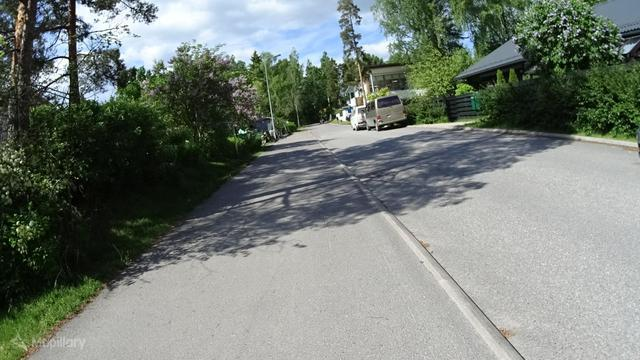

In [26]:
from PIL import Image
from IPython.display import display
img = Image.open(f"mappilary/train_val/{place}/database/images/{df['key'][sample]}.jpg")
display(img)


In [27]:
def dict_to_html_table(dictionary):
    html = "<table border='1'>\n"
    html += "<tr><th>Key</th><th>Value</th></tr>\n"

    for key, value in dictionary.items():
        html += f"<tr><td>{key}</td><td>{value}</td></tr>\n"

    html += "</table>"
    return html


In [28]:
import folium

import folium.plugins as plugins
from folium.plugins import HeatMap

map_center=[df['lat'][sample], df['lon'][sample]]
# mymap = folium.Map(location=map_center, zoom_start=10)
mymap = folium.Map(location=map_center, zoom_start=18)


# Add points to the map
count = 10
# for index, row in df.sample(n=count).iterrows():
folium.Marker([df['lat'][sample],df['lon'][sample]]).add_to(mymap)
for node in result.nodes:
        if not node.id in skip:
            folium.CircleMarker(
                location=[node.lat, node.lon],
                radius=10,
                fill=True,
                popup=folium.Popup(dict_to_html_table(node.tags)),
            ).add_to(mymap)



tile = folium.TileLayer(
      tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
      attr = 'Esri',
      name = 'Esri Satellite',
      overlay = False,
      control = True
      ).add_to(mymap)
folium.LayerControl().add_to(mymap)  
mymap

In [31]:
import io

map_center=[df['lat'][sample], df['lon'][sample]]
mymap = folium.Map(location=map_center, zoom_start=18, zoomControl=False)

folium.Marker([df['lat'][sample],df['lon'][sample]]).add_to(mymap)
for node in result.nodes:
        if not node.id in skip:
            folium.CircleMarker(
                location=[node.lat, node.lon],
                radius=10,
                fill=True,
                popup=folium.Popup(dict_to_html_table(node.tags)),
            ).add_to(mymap)

tile = folium.TileLayer(
      tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
      attr = 'Esri',
      name = 'Esri Satellite',
      overlay = False,
      control = True
      ).add_to(mymap)

img_data = mymap._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

ModuleNotFoundError: No module named 'selenium'

In [32]:
hist_df = []
for node in result.nodes:
        if not node.id in skip:
            for key in node.tags:
               hist_df.append([key, node.tags[key]])

In [33]:
hist_df = pd.DataFrame(hist_df, columns=['Key', 'Value'])
# hist_df = hist_df['Key'].value_counts()


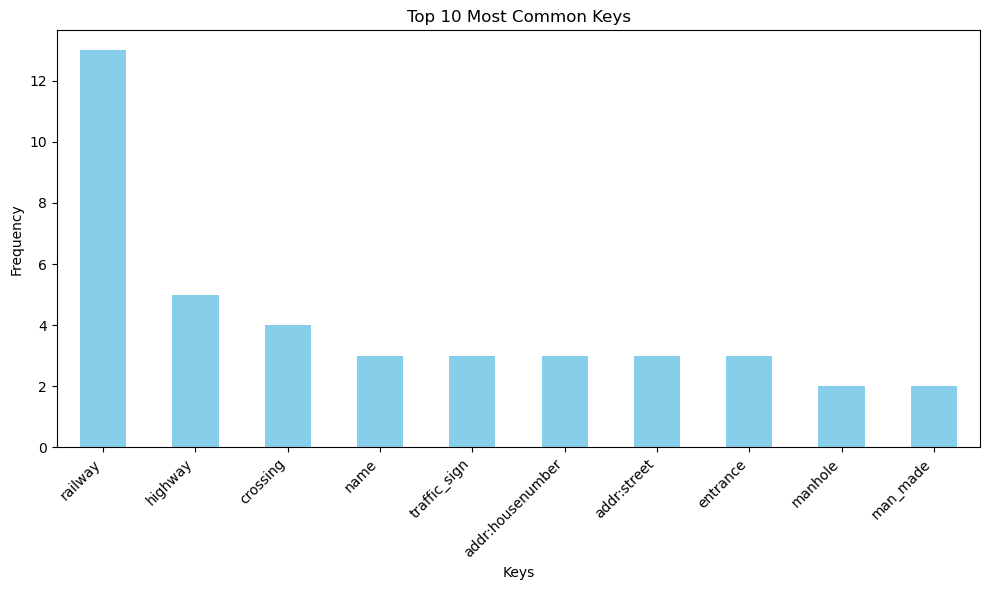

In [34]:
plt.figure(figsize=(10, 6))
key_counts = hist_df['Key'].value_counts()

key_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Keys')
plt.xlabel('Keys')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

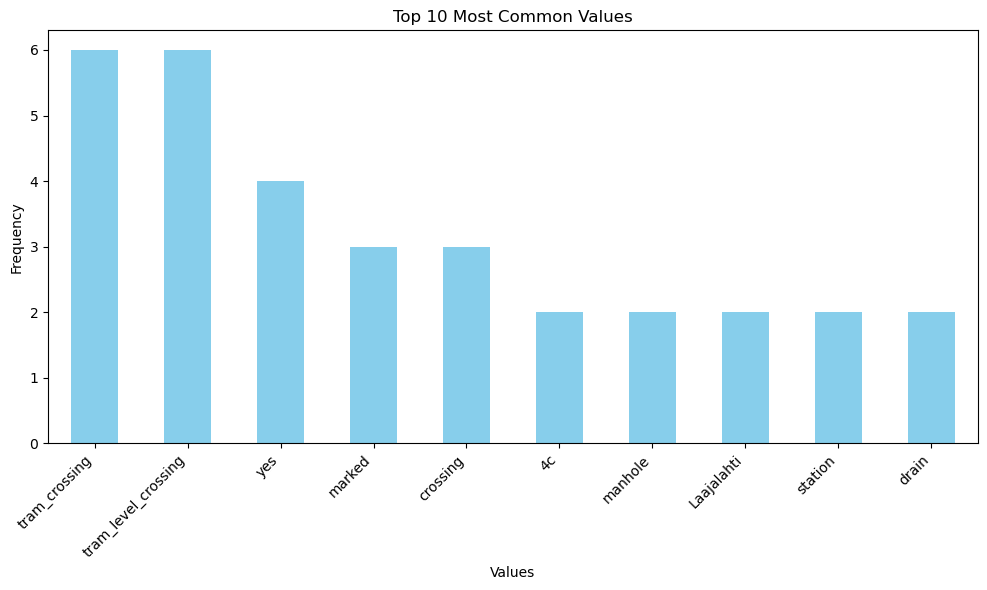

In [35]:
plt.figure(figsize=(10, 6))
val_counts = hist_df['Value'].value_counts()

val_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
import overpy
api = overpy.Overpass()

lat , lon = [df['lat'].mean(), df['lon'].mean()]
query = f"[out:json];node(around:1000, {lat}, {lon});out;"
print(query)
result = api.query(query)
hist_df = []
for node in result.nodes:
    if len(node.tags) == 0:
        continue
    if not node.id in skip:
        for key in node.tags:
            hist_df.append([key, node.tags[key]])
hist_df = pd.DataFrame(hist_df, columns=['Key', 'Value'])


[out:json];node(around:1000, 60.18944157997173, 24.882807374837586);out;


In [37]:
#hist_df

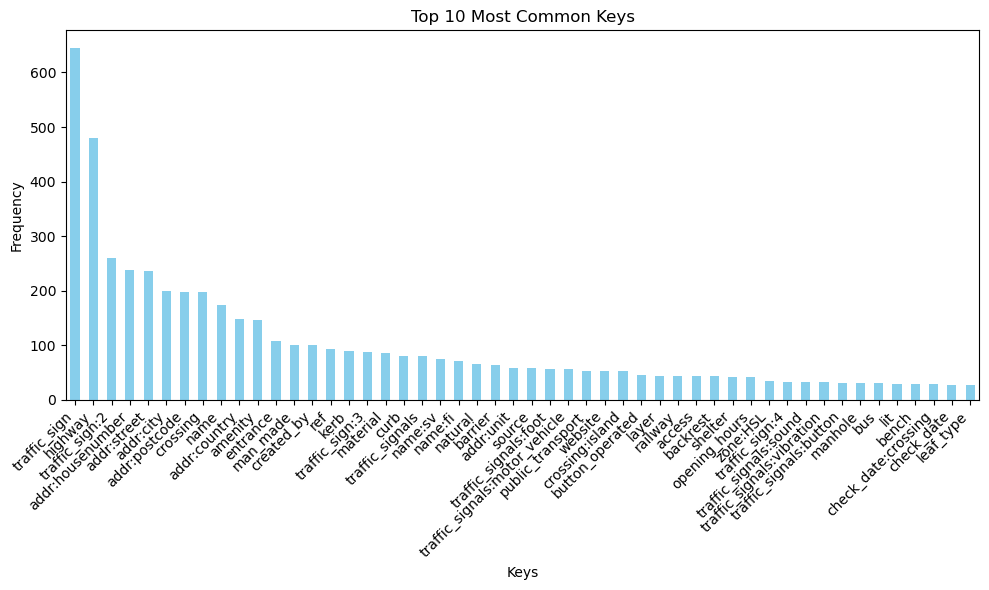

In [38]:
plt.figure(figsize=(10, 6))
key_counts = hist_df['Key'].value_counts()

key_counts.head(50).tail(50).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Keys')
plt.xlabel('Keys')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

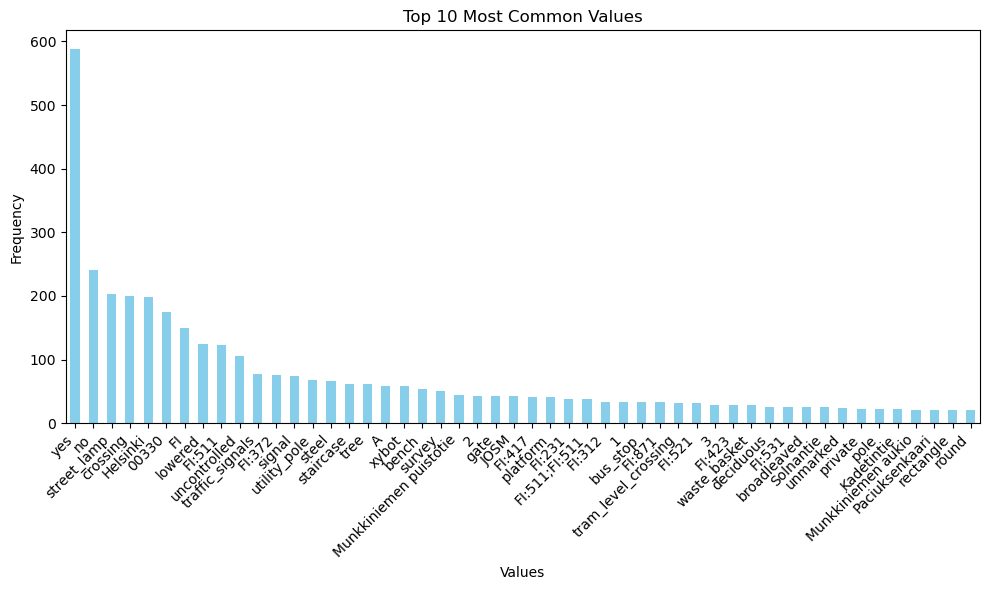

In [39]:
plt.figure(figsize=(10, 6))
val_counts = hist_df['Value'].value_counts()

val_counts.head(50).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Common Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
print("foo")

foo


In [41]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to("cuda")





/rds/general/user/ao921/home/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 592/592 [00:00<00:00, 3.85MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.56MB/s]
tokenizer.json: 100%|██████████| 711k/711k [00:00<00:00, 3.18MB/s]
special_tokens_map.json: 100%|██████████| 125/125 [00:00<00:00, 1.00MB/s]
config.json: 100%|██████████| 4.56k/4.56k [00:00<00:00, 29.1MB/s]
model.safetensors: 100%|██████████| 1.54G/1.54G [00:04<00:00, 364MB/s]


NameError: name 'raw_image' is not defined

In [43]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
# raw_image = Image.open("/content/streetmap.png").convert('RGB')
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
question = "Do the vehicles drive on the left or right"
inputs = processor(img, question, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

/rds/general/user/ao921/home/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


left
